# Случайные процессы. Прикладной поток.
## Практическое задание 4

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 4"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `4.N.ipynb` и `4.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* При проверке никакой код запускаться не будет.


--------------

Для выполнения задания потребуются следующие библиотеки: hmmlearn, librosa. Следующими командами можно их поставить (Ubuntu):

sudo pip3 install hmmlearn

sudo pip3 install librosa


--------------

### 1. Скрытые марковские модели (2 балла)

Реализация методов является полезной, но технически сложной, поэтому мы воспользуемся готовой реализацией `hmmlearn`. Документация http://hmmlearn.readthedocs.io/. Интерфейс данной библиотеки максимально близок к библиотеке `scikit-learn`. 

Все необходимые комментарии по интерфейсу библиотеки `hmmlearn` приведены в коде далее. Следуйте указаниям.

In [160]:
import numpy as np
import sys
from hmmlearn import hmm

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Если при использовании библиотеки будут появлятся различные warnings,
# раскомментируйте и выполните следующий код
import warnings
warnings.filterwarnings("ignore")

Зададим некоторую скрытую марковскую модель

In [179]:
# Объявление скрытой марковской модели с двумя скрытыми состояниями, 
# в которой предполагается, каждое состояние может генерировать 
# гауссовский случайный вектор с произвольной матрицей ковариаций.
# Используется метод Витерби.
# Поставьте 'map', чтобы использовать метод forward-backward.
model = hmm.GaussianHMM(n_components=2, covariance_type='full', 
                        algorithm='viterbi')  # я ДОЛЖЕН или МОГУ поставить map? (TODO)

# Параметры марковской цепи - начальное состояние и матрица переходных вероятностей

model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.07, 0.93]]) 
# слишком хорошая матрица, большие диагональные значения.

# Параметры условных распределений Y_j при условии X_j - вектора средних и
# матрица ковариаций по количеству состояний. Поскольку в данном случае
# распределения одномерные, ниже записаны два вектора размерности 1
# и две матрицы размерности 1x1
model.means_ = np.array([[0.0], [3.0]])
model.covars_ = np.array([[[1]], [[1]]])

Сгенерируем некоторую последовательность с помощью определенной выше модели.

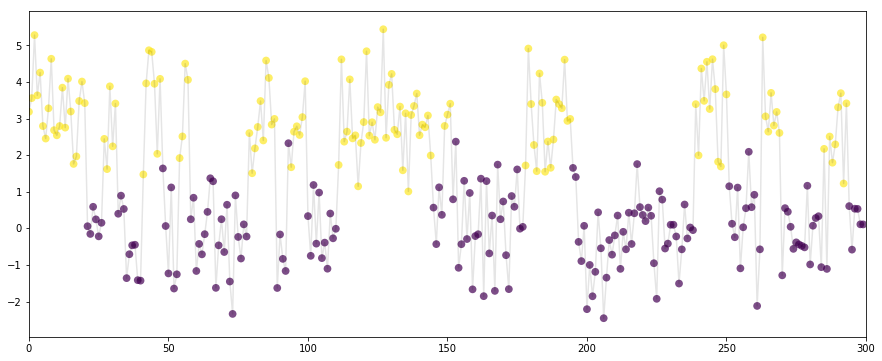

In [180]:
size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=np.array(X), lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.show()

На основе сгенерированной выше последовательности оценим параметры ("обучим") скрытой марковской модели и значения скрытых состояний.

In [181]:
# Объявление скрытой марковской модели, в которой при оценке параметров 
# будет производиться не более n_iter итераций EM-алгоритма.
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, algorithm='viterbi')

# Оценка параметров ("обучение")
remodel.fit(Y)  

# Оценка ("предсказание") значений скрытых состояний
X_predicted = remodel.predict(Y)

Теперь изобразим полученные результаты. На обоих графиках непрозразными маленькими кружочками отмечена исходная последовательность. Полупрозрачными большими кружочками отмечены оценки значений скрытых состояний. На первом графике отмечены все такие точки, на втором только те из них, оценка значения скрытого состояния получилась непрпавильно.

Accuracy =  0.98


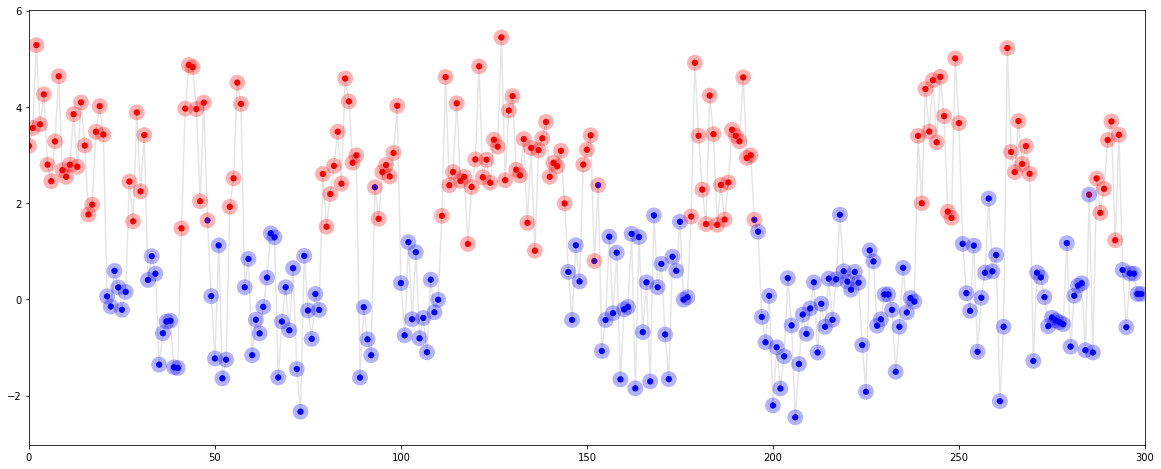

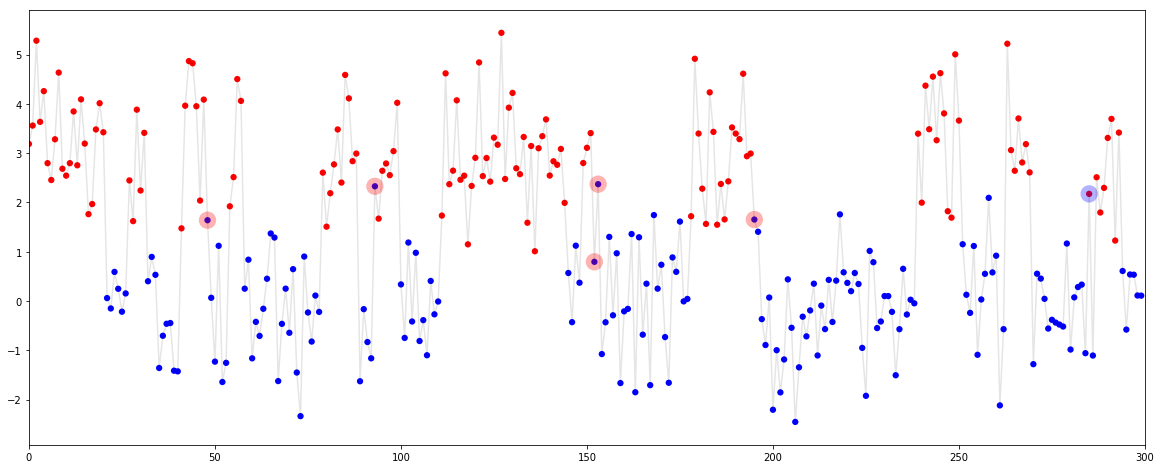

In [182]:
colors = np.array(['blue', 'red'])

# Состояния определяются с точностью до их перестановки.
# При необходимости меняем местами состояния
if (X != X_predicted).sum() > size / 2:
    X_predicted = 1 - X_predicted

print("Accuracy = ", (X == X_predicted).sum() / len(X))
    
plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X_predicted)], 
            lw=0, s=250, alpha=0.3)
plt.xlim((0, size))
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted], Y[:, 0][X != X_predicted], 
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()

Как понять, что EM-алгоритм сошелся? Для этого нужно посчитать значение некоторого функционала (см. презентацию), который умеет считать библиотека `hmmlearn`, поэтому мы всего лишь посмотрим на его значения. Данная функциональность в библиотеке реализованна слишком странно. Следуйте комментариям.

In [11]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

Теперь можно загрузить значения и построить график

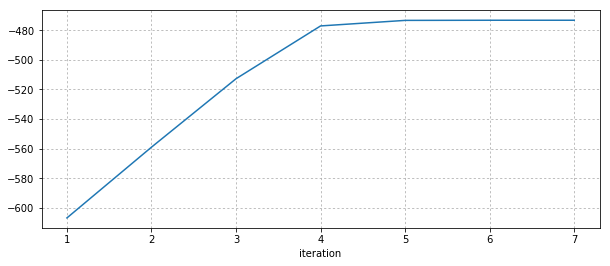

In [12]:
values = np.loadtxt('./est_values.txt')

plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.grid(ls=':')
plt.show()

Выполните те же операции для следующих двух случаев

* скрытая марковская цепь имеет три скрытых состояния;

* распределение $Y_j$ при условии $X_j$ является двумерным гауссовским.

## 1.1 Скрытая марковская цепь с тремя состояниями

Зададим требуемую сеть.

In [174]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full",
                       algorithm="viterbi")

# начальное рспределение и матрица переходов
model.startprob_ = np.array([1./6, 2./6, 3./6])
model.transmat_ = np.array([
    [1./6, 2./6, 3./6],
    [0.1, 0.4, 0.5],
    [0.1, 0.2, 0.8]
]) 
# сознательно испортим матрицу переходов, чтобы она была менее тривиальной,
# в сравнении с первым примером

# параметры условных распределений Y_j при условии X_j
model.means_ = np.array([
    [0.0],
    [3.0],
    [6.0]
])
model.covars_ = np.array([
    [[1.]],
    [[1.]],
    [[1.]]
])

Сгенерируем некоторую последовательность с помощью определенной выше модели.

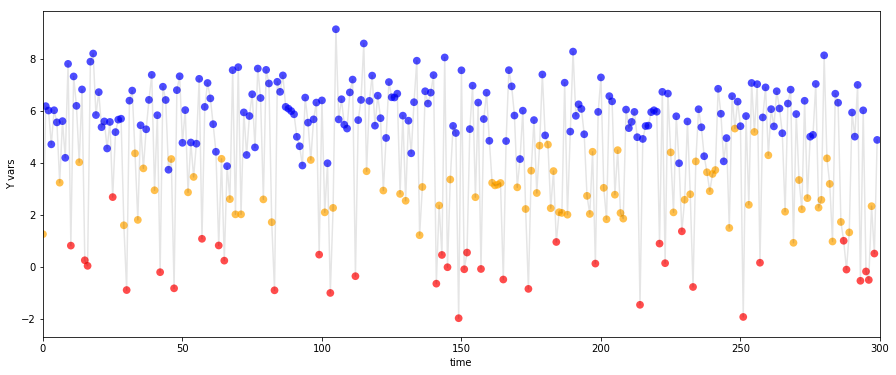

In [175]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["red", "orange", "blue"])  # чтобы было понятно, что к чему

size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=np.array(X), cmap=cmap, lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.xlabel("time")
plt.ylabel("Y vars")
plt.show()

Обучим скрытую марковскую модель на сгенерированных выше значениях.

In [176]:
# создадим модель, для обучения которой будет выполнено <= 100 итераций. 
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full",
                          n_iter=100, algorithm="viterbi")

# собственно, обучение
remodel.fit(Y)  

# предскажем значения скрытых состояний X для данных значений Y
X_predicted = remodel.predict(Y)

Так как состояния определяются с точностю до перестановки, подберём такую перестановку, чтобы accuracy (доля верных ответов) была максимальна.

In [177]:
import itertools
accuracy_list = []
permutation_list = []
for perm in itertools.permutations([0, 1, 2]):
    accuracy = 0  # считаем не долю, но количество
    for i in range(len(X)):
        accuracy += (perm[X_predicted[i]] == X[i])
    accuracy_list.append(accuracy / len(X))
    permutation_list.append(perm)
    
print("Accuracy / permutation = ", list(zip(accuracy_list, permutation_list)))
best_permutation = permutation_list[np.array(accuracy_list).argmax()]
print("Best permutation = ", best_permutation)
print("Best accuracy = ", accuracy_list[np.array(accuracy_list).argmax()])
X_predicted_recolored = np.array(list(
    map(lambda x: best_permutation[x], X_predicted)
))

print("X_predicted[:10] = ", X_predicted[:10])
print("X_predicted_recolored[:10]", X_predicted_recolored[:10])

Accuracy / permutation =  [(0.13, (0, 1, 2)), (0.19333333333333333, (0, 2, 1)), (0.18666666666666668, (1, 0, 2)), (0.016666666666666666, (1, 2, 0)), (0.85333333333333339, (2, 0, 1)), (0.62, (2, 1, 0))]
Best permutation =  (2, 0, 1)
Best accuracy =  0.853333333333
X_predicted[:10] =  [1 0 0 0 0 0 2 0 2 0]
X_predicted_recolored[:10] [0 2 2 2 2 2 1 2 1 2]


Теперь изобразим полученные результаты. На обоих графиках непрозразными маленькими кружочками отмечена исходная последовательность. Полупрозрачными большими кружочками отмечены оценки значений скрытых состояний. На первом графике отмечены все такие точки, на втором только те из них, оценка значения скрытого состояния получилась непрпавильно.

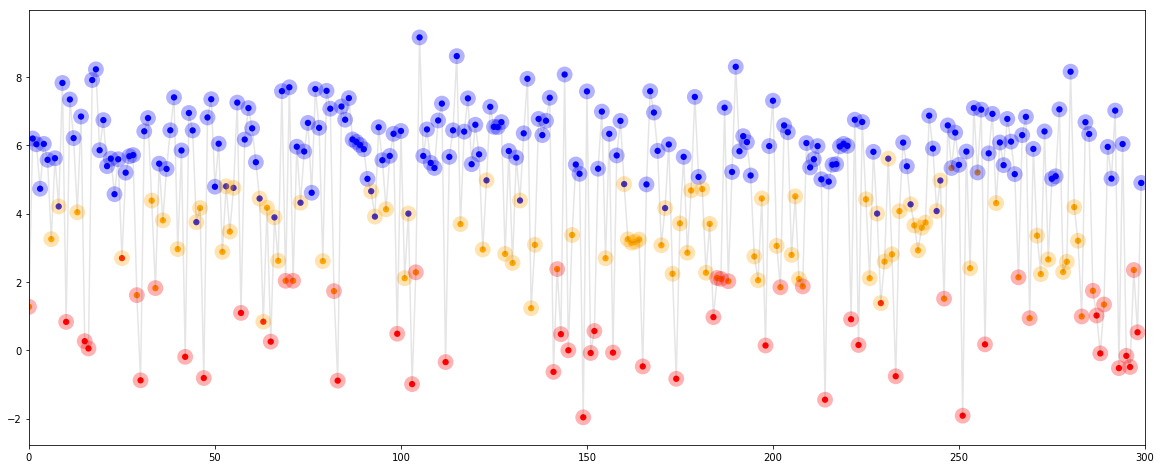

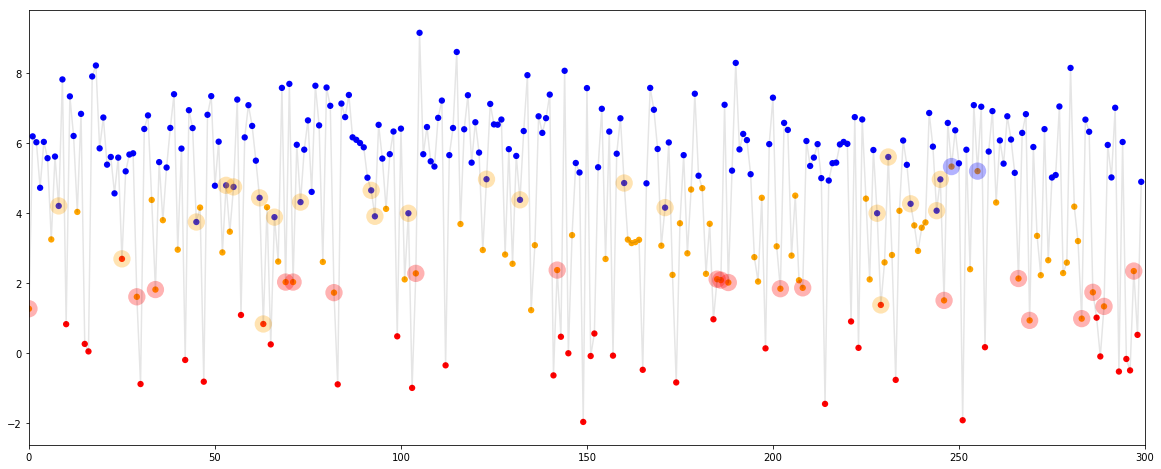

In [178]:
colors = np.array(["red", "orange", "blue"])
cmap = ListedColormap(colors)

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X_predicted_recolored)], 
            lw=0, s=250, alpha=0.3)
plt.xlim((0, size))
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted_recolored], Y[:, 0][X != X_predicted_recolored], 
            c=colors[np.array(X_predicted_recolored)[X != X_predicted_recolored]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()

Посмотрим на график (не) сходимости, как в примере.

In [98]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values_1.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

Теперь можно загрузить значения и построить график

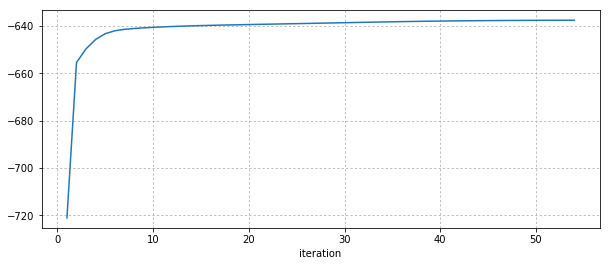

In [99]:
values = np.loadtxt('./est_values_1.txt')

plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.grid(ls=':')
plt.show()

## 1.2 Распределение $Y_j$ при условии $X_j$ является двумерным гассовым

Зададим некоторую скрытую марковскую модель

In [206]:
# объявим модель с двумя скрытыми стостояниями
model = hmm.GaussianHMM(n_components=2, covariance_type='full', 
                        algorithm='viterbi')  # я ДОЛЖЕН или МОГУ поставить map? (TODO)

# параметры марковской цепи возьмём из примера
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.07, 0.93]])
# в этом случае матрицу переходов мы портить не будем, 
# но дисперсии сделаем побольше, для вывода.

# зададим параметры двумерного распределения
model.means_ = np.array([
    [0.0, 0.0],
    [3.0, 3.0]
])
model.covars_ = np.array([
    [[4., 0.], [0., 4.]],
    [[4., -1], [-1, 4.]]
])
# в этом примере

# неплохо бы проверить положительную определённость матриц.
# воспользуемся критерием Сильвстра
for comp_i in range(model.covars_.shape[0]):
    for i in range(1, model.covars_.shape[1] + 1):
        assert (np.linalg.det(model.covars_[comp_i, :i, :i])) > 0

Сгенерируем некоторую последовательность с помощью определенной выше модели и визуализируем её на трёхмерном графике.

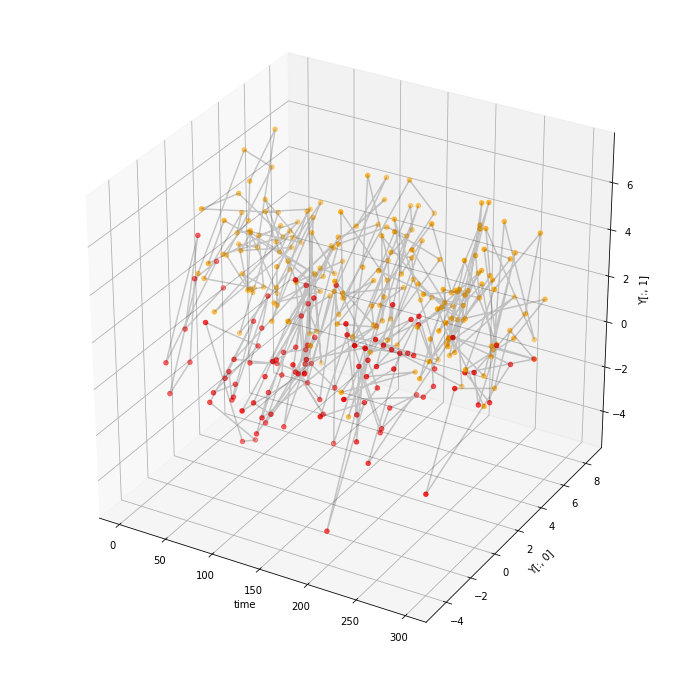

In [207]:
size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

from matplotlib.colors import ListedColormap
cmap = ListedColormap(["red", "orange"])  # чтобы было понятно, что к чему
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.scatter(np.arange(size), Y[:, 0], Y[:, 1], c=np.array(X), cmap=cmap)
ax.plot(np.arange(size), Y[:, 0], Y[:, 1], color='black', alpha=0.2)
ax.set_xlabel("time")
ax.set_ylabel("Y[:, 0]")  # более подробного, но короткого описания не придумал
ax.set_zlabel("Y[:, 1]")
plt.show()

На основе сгенерированной выше последовательности оценим параметры ("обучим") скрытой марковской модели и значения скрытых состояний.

In [208]:
# Объявление скрытой марковской модели, в которой при оценке параметров 
# будет производиться не более n_iter итераций EM-алгоритма.
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, algorithm='viterbi')

# Оценка параметров ("обучение")
remodel.fit(Y)  

# Оценка ("предсказание") значений скрытых состояний
X_predicted = remodel.predict(Y)

Теперь изобразим полученные результаты. На обоих графиках непрозразными маленькими кружочками отмечена исходная последовательность. Полупрозрачными большими кружочками отмечены оценки значений скрытых состояний. На первом графике отмечены все такие точки, на втором только те из них, оценка значения скрытого состояния получилась непрпавильно.

In [209]:
# Состояния определяются с точностью до их перестановки.
# При необходимости меняем местами состояния

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(X, X_predicted)  
if accuracy < 0.5:
    X_predicted = 1 - X_predicted
    accuracy = 1. - accuracy
# этот код делает абсолютно то же, что и код в примере
    

print("Accuracy = ", accuracy)

Accuracy =  0.976666666667


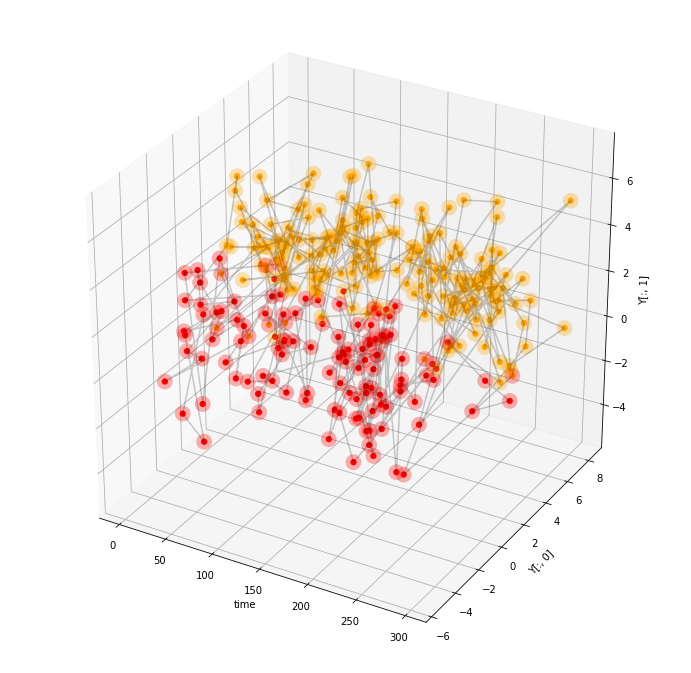

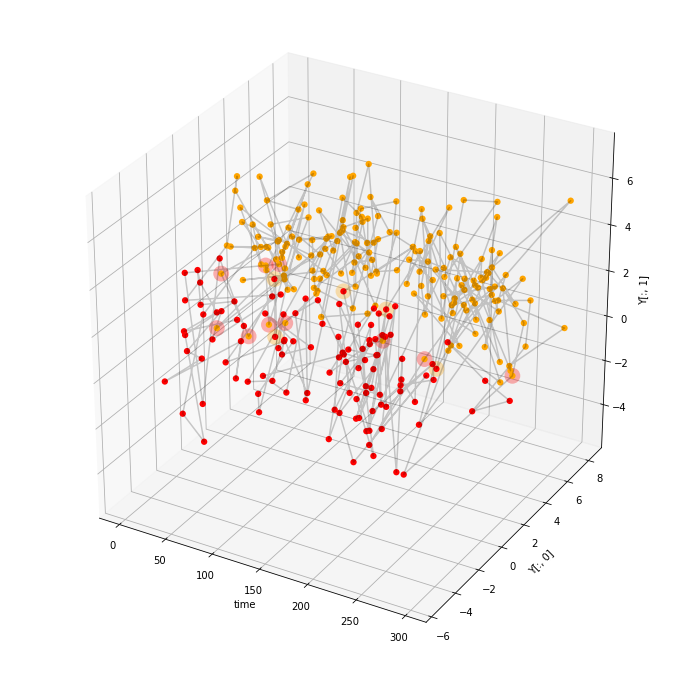

In [187]:
colors = np.array(["red", "orange"])
cmap = ListedColormap(colors)  

# Первый график
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

ax.plot(np.arange(size), Y[:, 0], Y[:, 1], color='black', alpha=0.2)
ax.scatter(np.arange(size), Y[:, 0], Y[:, 1], c=colors[np.array(X)], cmap=cmap,
          lw=0, s=40, alpha=1)
ax.scatter(np.arange(size), Y[:, 0], Y[:, 1], c=colors[np.array(X_predicted)], 
            lw=0, s=250, alpha=0.3)
ax.set_xlabel("time")
ax.set_ylabel("Y[:, 0]")
ax.set_zlabel("Y[:, 1]")
plt.show()

# Второй график
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

ax.plot(np.arange(size), Y[:, 0], Y[:, 1], color='black', alpha=0.2)
ax.scatter(np.arange(size), Y[:, 0], Y[:, 1], c=colors[np.array(X)], cmap=cmap,
          lw=0, s=40, alpha=1)
ax.scatter(np.arange(size)[X != X_predicted],
           Y[:, 0][X != X_predicted],
           Y[:, 1][X != X_predicted],
           c=colors[np.array(X_predicted[X != X_predicted])], 
            lw=0, s=250, alpha=0.3)
ax.set_xlabel("time")
ax.set_ylabel("Y[:, 0]")
ax.set_zlabel("Y[:, 1]")
plt.show()

Посмотрим на график (не) сходимости, как в примере.

In [169]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values_2.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

Теперь можно загрузить значения и построить график

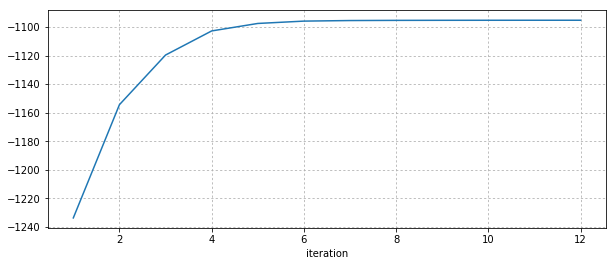

In [170]:
values = np.loadtxt('./est_values_2.txt')

plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.grid(ls=':')
plt.show()

**Дополнительно: ** вычислим точность предсказания классов, в предположении, что мы бы знали значения X и пытались использовать логистическую регрессию.

In [216]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
LR = LogisticRegression(random_state=1)
LR.fit(Y, X)
scoring = cross_validation.cross_val_score(LR, Y, X, scoring = 'accuracy', cv = 3)
print("LogisticRegression accuracy = ", scoring.mean())

LogisticRegression accuracy =  0.856423642364


In [ ]:
<Код с пояснениями, графики>

**Вывод:** Была испытана библиотека hmmlearn.hmm в трёх ситуациях

В первой ситуации марковская цепь $X$ имела простую матрицу переходов - большие ($\geq 0.9$) значения на диагонялях - это означает, что если предыдущее состояние было A, то следующее с высокой вероятностью будет A.

Более того, условные распределения были $\mathcal{N}(0, 1)$ и $\mathcal{n}(3,1)$ - предсказывать состояния $X$, можно было бы и с помощью критерия вида $I[Y > Y.mean() ~ 1.5]$, хотя и со значимо меньшей долей верно угаданных состояний, что видно из графика - несколько значений, более близких к 3 (состояние 1), но имеющих предыдущее состояние 0, алгоритм относит к состоянию 0, что он и должен делать, максимизируя правдоподобие. В итоге имеем очень высокую долю угаданных состояний = 0.98. В данных условиях hmm работает почти идеально.
 
Во второй ситуации была взята менее тривиальная матрица переходов, а пропорции распределений не менялись - $\mathcal{N}(0, 1)$, $\mathcal{n}(3,1)$ и  $\mathcal{n}(6,1)$ (шаг - 3, дисперсия - 1). В итоге, состояние 2, для которого вероятность перейти из себя в себя равна 0.8 угадывается достаточно хорошо (а ещё он просто с края, а не по середине, что также упрощает предсказание). При это состояния 0 и 1, для которых зависимости менее тривиальны, определяются хуже. Однако, в том числе, из-за большого числа реальных состояний 2, имеем долю угаданных верно классов = 0.85(3), что (относительно, ибо зависимости действительно менее тревиальны в сравнении с первым примером) является высокой точностью.

В третьей ситуации была взята матрица переходов из первой ситуации, но Y были распредены двумерно, с дисперсией, обеспечивающей перекрытие областей значений Y двух классов, чтобы продемонстрировать ещё раз, что данный алгоритм именно пытается восстановить зависимости цепи X, а не реагирует только на значения, как делал бы метод с индикатором. В итоге - для двумерного случая имеем долю угаданных значений = 0.97(6) [при том, что даже если бы мы знали метки X, и пытались бы использовать логистическую регрессию для предсказания (т.е. выкинули бы информацию о том, что есть какая-то скрытая цепь и пытались бы провести разделяющую гиперплоскость, оптимальную в известном смысле), то получили бы 0.85(6423), что тоже не плохо, но явно значимо уступает почти идеальной hmm]


Кроме гауссовского случая в библиотеке реализовано два других

* `hmm.GMMHMM` --- распределение $Y_j$ при условии $X_j$ является смесью гауссовских распределений, 
* `hmm.MultinomialHMM` --- распределение $Y_j$ при условии $X_j$ является дискретным.

### 2. Музыка (предполагалось на семинаре, оцениваться не будет)

Некоторый вспомогательный код.

In [239]:
import librosa
from IPython import display

def Audio(url):
    return display.HTML("<center><audio controls><source src='{}'" +
                        "type=\"audio/wav\"></audio>".format(url))

Загрузите сюда некоторый музыкальный трек. Тут же вы его можете послушать.

In [240]:
sound_file = "track.wav"  # mp3 не пошёл.
Audio(url=sound_file)

Изобразим графики амплитуды для разной sampling rate (sr).

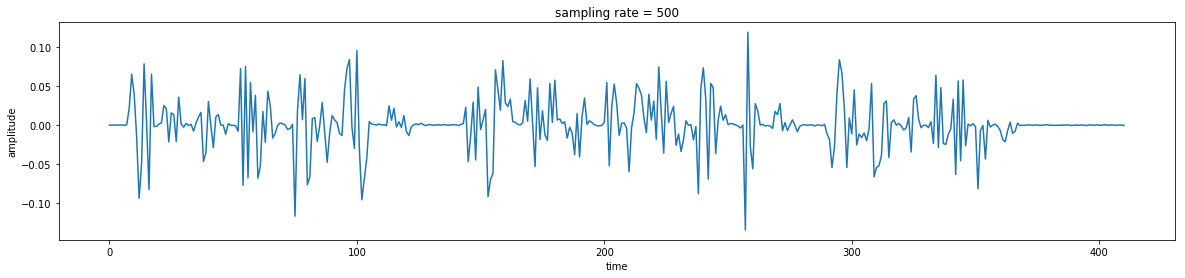

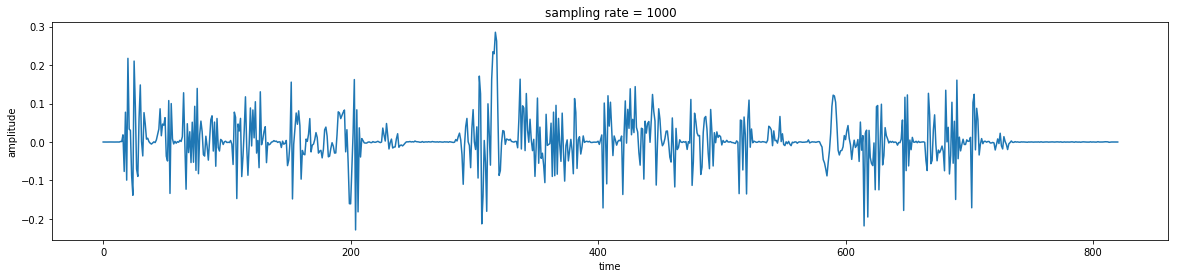

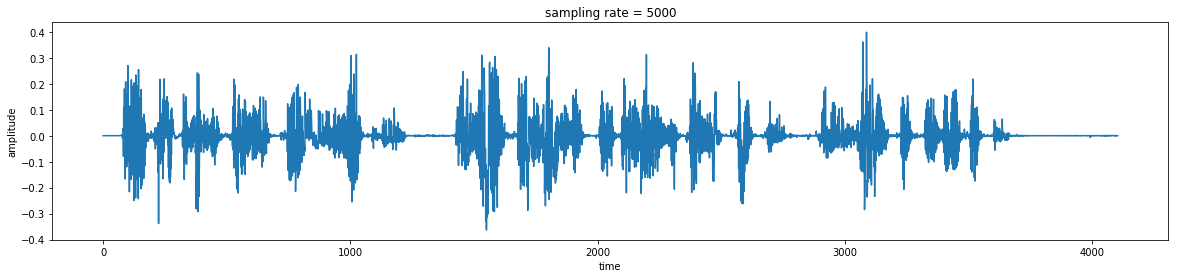

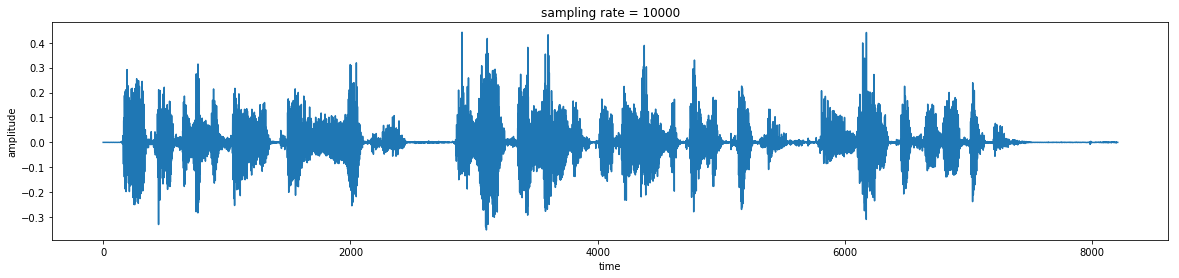

In [241]:
for sr in [500, 1000, 5000, 10000]:
    plt.figure(figsize=(20, 4))
    y, sr = librosa.load(sound_file, sr=sr)
    plt.plot(y[:1000000:10])
    plt.ylabel("amplitude")
    plt.xlabel("time")
    plt.title('sampling rate = {}'.format(sr))
    plt.show()

Изобразим спектрограмму

In [245]:
sr = 1500

# Если ваш ноутбук не справляется с чем-то, уменьшите параметр n_mels
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=30)
log_S = librosa.logamplitude(S, ref_power=np.max)

plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', 
                         y_axis='mel', cmap='hot')  # ???? Ладно, пропустим.
plt.title('power spectrogram') 
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

AttributeError: module 'librosa' has no attribute 'display'

Если выполнить операцию транспонирования, то мы получим некоторый многомерный случайный процесс. К нему уже можно применить скрытую марковскую модель.

In [ ]:
Y = log_S.T

Соберите коллекцию музыкальных треков одного стиля или же одного исполнителя.

**Варианты задания:**
1. Объедините спектрограммы всех треков коллекции в одну большую спектрограмму и выполните на ней обучение скрытой марковской модели. Сколько итераций потребовалось EM-алгоритму для сходимости? Какие по смыслу состояния были обнаружены? Примените модель к новым трекам того же стиля.
2. Вручную разбейте все треки на припев и все остальное, это будут скрытые состояния. Оцените вручную все параметры модели. Примените модель к новым трекам. Какое получается качество?

### 3. Part-of-speach tagging (8 баллов)

Теперь вам нужно самостоятельно реализовать метод распознавания частей речи для слов в предложении на основе скрытых марковских моделей. Метод реализовать можно с помощью библиотеки `hmmlearn`, но хранение разреженных матриц в в формате обычных матриц потребует большого количества памяти, поэтому на этот раз реализовать HMM придется самостоятельно. 

Будем считать, что каждый следующий тег непосредственно зависит только от двух предыдущих. Такая модель является марковской цепью, если в качестве состояний рассматривать все возможные пары тегов, причем матрица переходных вероятностей будет разреженной. Чтобы однозначно задать матрицу переходных вероятностей достаточно определить вероятности $\mathsf{P}(X_3=tag_3 \left| X_2=tag_2, X_1=tag_1\right)$, в качестве которых возьмем их оценку максимального правдоподобия (см. семинар). Сделайте так же оценку вероятностей $\mathsf{P}(Y_i=word \left| X_i=tag\right)$ для определения распределения слов для каждого тега.

Для удобства реализации можно считать, что перед началом предложения и после конца предложения находится несколько "пустых" тегов.

После того, как определена модель, нужно реализовать функцию, которая по заданному предложению для данной модели будет находить траекторию Витерби. Эта траектория и будет являться оценкой последовательности тегов для данного предложения. Посчитайте точность определения тегов на тестовом наборе данных.

**Данные** возьмите такие же, как в примере с семинара.

Сравните точность вашей модели с простой моделью, которая была показана на семинаре, а так же со следующими встроенными моделям:

_________________
Загрузим данные

In [172]:
import numpy as np
import nltk  # sudo pip3 install nltk
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score

In [173]:
# nltk.download()

In [174]:
from nltk.corpus import conll2000

По-хорошему, надо использовать train_test_split или хотя бы перемешать данные, ибо такое тестирование потенциально некорректно (а вдруг предложения как-то отсортированы), но раз данные как в примере с семинара - значит данные как в примере с семинара.

In [175]:
train_sents = conll2000.tagged_sents()[:8000]  
test_sents = conll2000.tagged_sents()[8000:]  

In [176]:
train_sents

[[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ('pound', 'NN'), ('is', 'VBZ'), ('widely', 'RB'), ('expected', 'VBN'), ('to', 'TO'), ('take', 'VB'), ('another', 'DT'), ('sharp', 'JJ'), ('dive', 'NN'), ('if', 'IN'), ('trade', 'NN'), ('figures', 'NNS'), ('for', 'IN'), ('September', 'NNP'), (',', ','), ('due', 'JJ'), ('for', 'IN'), ('release', 'NN'), ('tomorrow', 'NN'), (',', ','), ('fail', 'VB'), ('to', 'TO'), ('show', 'VB'), ('a', 'DT'), ('substantial', 'JJ'), ('improvement', 'NN'), ('from', 'IN'), ('July', 'NNP'), ('and', 'CC'), ('August', 'NNP'), ("'s", 'POS'), ('near-record', 'JJ'), ('deficits', 'NNS'), ('.', '.')], [('Chancellor', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('Exchequer', 'NNP'), ('Nigel', 'NNP'), ('Lawson', 'NNP'), ("'s", 'POS'), ('restated', 'VBN'), ('commitment', 'NN'), ('to', 'TO'), ('a', 'DT'), ('firm', 'NN'), ('monetary', 'JJ'), ('policy', 'NN'), ('has', 'VBZ'), ('helped', 'VBN'), ('to', 'TO'), ('prevent', 'VB'), ('a', 'DT'), ('freefall', 'NN'), ('in', 'IN'), ('s

К сожалению, не все предложения заканчиваются точкой, что немного портит нам жизнь.

In [177]:
for sent in conll2000.tagged_sents():
    if (sent[-1][0] != "."):
        print(sent)
        break

[('Thursday', 'NNP'), (',', ','), ('he', 'PRP'), ('reminded', 'VBD'), ('his', 'PRP$'), ('audience', 'NN'), ('that', 'IN'), ('the', 'DT'), ('government', 'NN'), ('``', '``'), ('can', 'MD'), ('not', 'RB'), ('allow', 'VB'), ('the', 'DT'), ('necessary', 'JJ'), ('rigor', 'NN'), ('of', 'IN'), ('monetary', 'JJ'), ('policy', 'NN'), ('to', 'TO'), ('be', 'VB'), ('undermined', 'VBN'), ('by', 'IN'), ('exchange', 'NN'), ('rate', 'NN'), ('weakness', 'NN'), ('.', '.'), ("''", "''")]


Посмотрим на число различных тегов в обучающей выборке (чтобы понять, что ставить неизвестным словам, например). Кстати, для тега, разделяющего предложения подходит точка. (см данные)

In [178]:
tags_summary = dict()
for sent in train_sents:
    for word, tag in sent:
        if tag in tags_summary:
            tags_summary[tag] += 1
        else:
            tags_summary[tag] = 1
print(tags_summary)

{'IN': 20432, 'NNP': 17579, 'WDT': 871, 'NNPS': 372, 'VBD': 5892, 'JJ': 11779, 'VBP': 2651, 'JJS': 338, 'SYM': 6, 'UH': 15, ':': 932, 'RP': 70, 'VBZ': 4291, 'RBS': 172, '(': 235, 'WP$': 33, 'NNS': 12282, 'PDT': 48, '#': 32, 'RBR': 301, 'CC': 4855, 'VBG': 2956, '``': 1396, 'RB': 6010, '$': 1534, 'DT': 16556, 'JJR': 767, 'VBN': 4238, 'NN': 27005, 'TO': 4523, '.': 7899, 'CD': 7070, 'MD': 1950, 'VB': 5443, 'FW': 37, ')': 242, 'PRP': 3510, 'WRB': 433, 'POS': 1575, 'WP': 488, 'EX': 185, ',': 9639, "''": 1360, 'PRP$': 1700}


Чаще всего встречаются NN, собственно, в примере, неизвестным словам давался NN.

Составим словарь всех слов, чтобы работать с цифрами, а не строками.

In [179]:
words = dict()
for sent in train_sents:
    for word, tag in sent:
        word = word.lower()  # конечно, confidence и Confidence - одно слово
        total = len(words)
        if not (word in words):
            words[word] = total
            
len(words)

16385

Аналогично - для тегов.

In [180]:
tags = dict()
for sent in train_sents:
    for word, tag in sent:
        total = len(tags)
        if not (tag in tags):
            tags[tag] = total
            
print(tags, len(tags))

{'IN': 1, 'NNP': 10, 'WDT': 34, 'NNPS': 28, 'VBD': 21, 'JJ': 8, 'VBP': 15, 'JJS': 30, 'SYM': 42, 'UH': 43, ':': 39, 'RP': 38, 'VBZ': 3, 'RBS': 36, '(': 25, 'WP$': 41, 'NNS': 9, 'PDT': 37, '#': 24, 'RBR': 32, 'CC': 12, 'VBG': 16, '``': 19, 'RB': 4, '$': 26, 'DT': 2, 'JJR': 33, 'VBN': 5, 'NN': 0, 'TO': 6, '.': 14, 'CD': 18, 'MD': 23, 'VB': 7, 'FW': 40, ')': 27, 'PRP': 29, 'WRB': 35, 'POS': 13, 'WP': 31, 'EX': 22, ',': 11, "''": 20, 'PRP$': 17} 44


Сделаем две маленькие, но приятные функции, кодирующие - декодирующие пару тегов

In [181]:
def encode_tag_pair(t1, t2):
    return t1 * len(tags) + t2

def decode_tag_pair(code):
    return int(code) // len(tags), int(code) % len(tags)

Создадим выборку, собственно

In [187]:
sep = "."  # разделитель предложений
sep_id = tags[sep]

y = []
for sent in train_sents:
    for word, tag in sent:
        y.append(words[word.lower()])
    y.append(sep_id)

    
X = []
last_tag = sep_id  # точка - это тег
for sent in train_sents:
    for word, tag in sent:
        tag_id = tags[tag]
        X.append(encode_tag_pair(last_tag, tag_id))
        last_tag = tag_id
    X.append(encode_tag_pair(last_tag, sep_id))
    last_tag = sep_id
    
print(y[:5], len(y))  # логично, некоторый префикс есть 0, 1, 2 ...
print(X[:5], len(X))  # на втором месте стоит, очевидно, 0 * len(T) + 1

[0, 1, 2, 3, 4] 197702
[616, 1, 46, 88, 3] 197702


Вычислим некоторые константы.

In [184]:
r = len(tags) * len(tags)  # число состояний скрытой цепи Маркова ~ 2e3
T = len(X)  # длина выборки, на которой ищем ОМП ~ 2e5
Y_max = len(words)  # число принимаемых Y значений ~ 2E4

r, T, Y_max

(1936, 197702, 16385)

Оценим условные вероятности $P(Y_i = w|X_i = t)$ частотным методом.

In [186]:
condition_prob_matrix = np.zeros((Y_max, len(tags)))  # матрица переходов
# все пары ненулевых элементов prob_matrix, каждая по одному разу

for i in range(len(X)):
    t1, t2 = decode_tag_pair(X[i])
    condition_prob_matrix[y[i], t2] += 1  # считаем сумму I(Yi =w, Xi = t)

###########
#### Костыль, чтобы не было нулей в вероятностях
# condition_prob_matrix += 1. / (condition_prob_matrix.shape[0] * condition_prob_matrix.shape[1])
#############
cnt_xi = condition_prob_matrix.sum(axis = 0)  # сумма I(Xi = t)

for y_value in range(Y_max):
    for tag in range(len(tags)):
        condition_prob_matrix[y_value, tag] /= cnt_xi[tag]
        
condition_prob_matrix.sum(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.])

Оценим переходные вероятности методом наибольшего правдоподобия, как говорилось на семинаре.

In [188]:
nij = np.zeros((r, r), dtype=float)  # nij = sum_k I(X_{k-1} =i, X_k = j)
ni = np.zeros(r, dtype=int) #ni = sum_j nij

for i in range(len(X) - 1):
    nij[X[i], X[i + 1]] += 1
    
##################
### Костыль для того, чтобы все тройки были возможны
for t1 in range(len(tags)):
    for t2 in range(len(tags)):
        for t3 in range(len(tags)):
            x1 = encode_tag_pair(t1, t2)
            x2 = encode_tag_pair(t2, t3)
            nij[x1][x2] += 1. / r
##################
    
ni = nij.sum(axis = 1)

prob_matrix = np.array([[
    nij[i, j] / ni[i] if nij[i, j] > 0 else 0 for j in range(r)]
    for i in range(r)
])
# именно поэлементное деление

print(prob_matrix.sum(axis = 1))
# должны быть 1 для достижимых состояний и 0 для недостижимых
# (т.е. таких пар, которых не встретилось в обучающей выборке)

# проверим, что корректно подсчиталось
for i, val in enumerate(prob_matrix.sum(axis = 1)):
    assert (((abs(val -1.) < 1e-9) and (ni[i] > 0))
    or ((abs(val - 0.) < 1e-9) and (ni[i] == 0)))

valid_states = np.arange(r)[(ni > 0)]  # вычислим достижимые состояния, чтобы рассматривать далее только их
print(valid_states, len(valid_states))

[ 1.  1.  1. ...,  1.  1.  1.]
[   0    1    2 ..., 1933 1934 1935] 1936


В конце-концов оценим начальное распределение. Для этого посмотрим в данные и вычислим частотным образом вероятности появления какого-то тега в начале предложения. Предложения разделяются точкой, так что все начальные состояния будут иметь вид encode_tag_pair(tags["."], ?)

In [189]:
start_probs =  np.zeros(len(tags))
print("Training sentenses count = ", len(train_sents))
for sent in train_sents:
    start_probs[tags[sent[0][1]]] += 1
    
start_probs += 1. / len(train_sents)

print(start_probs.sum())
start_probs /= start_probs.sum()
print(start_probs, start_probs.sum())


Training sentenses count =  8000
8000.0055
[  4.54999843e-02   1.24874930e-01   2.12624869e-01   1.75001442e-03
   6.14999733e-02   4.87501227e-03   3.62501313e-03   5.12501210e-03
   4.39999854e-02   4.27499862e-02   1.90624885e-01   1.56249893e-08
   5.68749765e-02   1.56249893e-08   1.56249893e-08   3.75015367e-04
   1.38750061e-02   8.87500952e-03   1.63750044e-02   7.33749652e-02
   3.75015367e-04   1.25001477e-03   3.25001339e-03   6.25015195e-04
   1.56249893e-08   3.37501330e-03   1.56249893e-08   1.25015539e-04
   2.50015453e-04   6.03749741e-02   5.00001219e-03   3.62501313e-03
   2.37501399e-03   1.00001494e-03   6.25015195e-04   7.00001081e-03
   1.56249893e-08   1.56249893e-08   1.56249893e-08   2.37501399e-03
   1.56249893e-08   1.25015539e-04   5.00015281e-04   7.50015109e-04] 1.0


Итого, мы оценили переходные и условные вероятности. Теперь мы можем искать траекторию Витерби

In [143]:
from tqdm import tqdm_notebook, tnrange
from tqdm import tqdm
def my_log(f):
    if f != 0:
        return np.log(f)
    else:
        return 0. - np.inf
        
        
def eval_viterbi(y, log=False):
    T = len(y)

    g1 = np.zeros(r)
    for r_i in range(r):
        t1, t2 = decode_tag_pair(r_i)
        g1[r_i] = (my_log(start_probs[t2]) +
                     my_log(condition_prob_matrix[y[0], t2]))

    g = np.zeros((T, r, r))

    for x1 in range(r):
        for x2 in range(r):
            g[0, x1, x2] = g1[x2]

    for t in range(T):
        
        if (log):
            print(t, end=",")
            
        for x1 in range(r):
            t1, t2 = decode_tag_pair(x1)
            v2 = my_log(condition_prob_matrix[y[t], t2])
            for t3 in range(len(tags)):
                x2 = encode_tag_pair(t2, t3)
                v1 = my_log(prob_matrix[x1, x2])
                g[t, x1, x2] = v1 + v2
                
                
    ################
    if (log):
        print("G_dp")
        
    G_dp_vals = np.zeros((T, r))
    G_dp_ways = np.zeros((T, r), dtype=int)
    for k in range(r):  # инициализация ДП
        G_dp_vals[0, k] = g1[k]
        G_dp_ways[0, k] = -1 # храним пару - значение и номер ячейки, откуда пришли

    for t in range(1, T):
        
        if (log):
            print(t, end=",")
            
        for k in range(r):
            t1, t2 = decode_tag_pair(k)
            maximal = (G_dp_vals[t - 1, 0] + g[t, k, 0], 0)
            for t3 in range(len(tags)):
                l = encode_tag_pair(t2, t3)
                var = (G_dp_vals[t - 1, l] + g[t, k, l], l)
                if (maximal < var):
                    maximal = var
            G_dp_vals[t, k] = maximal[0]
            G_dp_ways[t, k] = maximal[1]
            
    #################
    
    k_star = G_dp_vals[T - 1, :].argmax()
    
    if (log):
        print((G_dp_vals[T-1, :] != -np.inf).sum())
        
    ans = [-1] * T
    for t in range(T)[::-1]:
        ans[t] = decode_tag_pair(k_star)[1]
        k_star = G_dp_ways[t, k_star]

    return ans

def tag(sent):
    y = []
    for word in sent:
        if word.lower() in words:
            y.append(words[word.lower()])
        else:
            print("fuck")
            y.append(words["this"])  # TODO заменить на что-то более разумное
    print("y = ", y)
    eval_viterbi(y)

def score_me(test_sent, log=False):
    if log:
        print("Score_me = ", test_sent)
    sent = [word for word, tag in test_sent]
    sent_tag = [tag for word, tag in test_sent]

    y = []
    for word in sent:
        if word.lower() in words:
            y.append(words[word.lower()])
        else:
            if log:
                print("fuck:", word)
            y.append(words[","])  # TODO заменить на что-то более разумное
    if log:
        print("y = ", y)

    X = []
    for tag in sent_tag:
        X.append(tags[tag]) 
    if log:
        print("X = ", X)
                
    X_predict = eval_viterbi(y)
    if log:
        print("X_predict = ", X_predict)
    acc_score = accuracy_score(X_predict, X)
    if log:
        print("Accuracy = ", acc_score)
    return ((np.array(X_predict) == np.array(X)).sum(), len(X))
                

In [144]:
print(len(test_sents))

2948


In [154]:
def set_nij(param, log=False):
    global nij
    global ni
    global prob_matrix
    global valid_states
    nij = np.zeros((r, r), dtype=float)  # nij = sum_k I(X_{k-1} =i, X_k = j)
    ni = np.zeros(r, dtype=int) #ni = sum_j nij

    for i in range(len(X) - 1):
        nij[X[i], X[i + 1]] += 1

    ##################
    ### Костыль для того, чтобы все тройки были возможны
    for t1 in range(len(tags)):
        for t2 in range(len(tags)):
            for t3 in range(len(tags)):
                x1 = encode_tag_pair(t1, t2)
                x2 = encode_tag_pair(t2, t3)
                nij[x1][x2] += 1. / param
    ##################

    ni = nij.sum(axis = 1)

    prob_matrix = np.array([[
        nij[i, j] / ni[i] if nij[i, j] > 0 else 0 for j in range(r)]
        for i in range(r)
    ])
    # именно поэлементное деление

    if (log):
        print(prob_matrix.sum(axis = 1))
    # должны быть 1 для достижимых состояний и 0 для недостижимых
    # (т.е. таких пар, которых не встретилось в обучающей выборке)

    # проверим, что корректно подсчиталось
    for i, val in enumerate(prob_matrix.sum(axis = 1)):
        assert (((abs(val -1.) < 1e-9) and (ni[i] > 0))
        or ((abs(val - 0.) < 1e-9) and (ni[i] == 0)))

    valid_states = np.arange(r)[(ni > 0)]  # вычислим достижимые состояния, чтобы рассматривать далее только их
    if (log):
        print(valid_states, len(valid_states))
    

In [158]:
%%time
params = 1. / np.linspace(1., 100, 30)
ret = []
for param in params:
    set_nij(param)
    accs = np.array([score_me(train_sents[i*8000//50]) for i in range(50)])  # if (print(i, end=",") or True
    print("Accuracy on sents[i] = ", accs[:, 0] / accs[:, 1])
    total_accuracy = np.array(accs[:, 0].sum() / accs[:, 1].sum()).mean()
    print("Total accuracy = ", total_accuracy)
    ret.append((total_accuracy, param))


    print(ret)

Accuracy on sents[i] =  [ 0.75675676  0.75        0.84210526  0.70212766  0.71875     0.45454545
  0.68421053  0.88888889  0.9375      0.66666667  0.84615385  0.85
  0.72222222  0.88888889  0.72222222  0.88461538  0.76923077  0.88235294
  0.61111111  0.65625     0.86206897  0.85294118  0.78571429  0.74
  0.75757576  0.75        0.66666667  0.6         1.          0.89473684
  0.65217391  0.64        0.675       0.73333333  0.71428571  0.8
  0.64285714  0.83333333  1.          0.61904762  0.68965517  0.82352941
  0.83333333  0.93333333  0.57894737  0.63636364  0.75        0.7         1.
  0.64285714]
Total accuracy =  0.742194469224
Accuracy on sents[i] =  [ 0.75675676  0.75        0.84210526  0.72340426  0.71875     0.45454545
  0.73684211  0.88888889  0.9375      0.66666667  0.84615385  0.85
  0.72222222  0.88888889  0.72222222  0.88461538  0.76923077  0.82352941
  0.61111111  0.65625     0.86206897  0.85294118  0.85714286  0.74
  0.75757576  0.75        0.66666667  0.55        1.    

Saved =  True


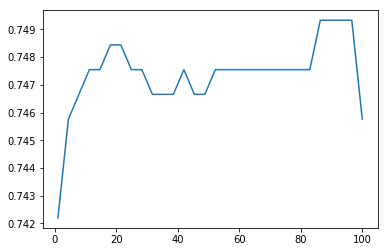

In [171]:
ret = np.array(ret)
import pickle
with open("ret_set_nij_param.pkl", "wb") as f:
    pickle.dump(ret, f)
    
with open("ret_set_nij_param.pkl", "rb") as f:
    check_ret_save = pickle.load(f)
    
print("Saved = ", (check_ret_save == ret).sum() == ret.shape[0] * ret.shape[1])

plt.figure()
plt.plot(1./ret[:, 1],  ret[:, 0])
plt.show()

___________________________________
Debug notes

In [ ]:
from tqdm import tqdm_notebook, tnrange
from tqdm import tqdm
def my_log(f):
    if f != 0:
        return np.log(f)
    else:
        return 0. - np.inf
        
        
def eval_viterbi(y):
    T = len(y)
    global r
    
    g1 = np.zeros(r)
    for r_i in valid_states:
        g1[r_i] = (my_log(start_probs[r_i]) +
                     my_log(condition_prob_matrix[y[0], r_i]))
        
    g = np.zeros((T, r, r))
    for t in range(T):
        for x1 in valid_states:
            for x2 in valid_states:
                g[t, x1, x2] = (my_log(prob_matrix[x1, x2]) +
                                my_log(condition_prob_matrix[y[t], x1]))
                
    G_dp = np.zeros((T, r))
    for k in valid_states:  # инициализация ДП
        G_dp[0, k] = (g1[k], -1)  # храним пару - значение и номер ячейки, откуда пришли
        
    for t in range(1, T):
        for k in valid_states:
            maximal = (G_dp[t - 1, 0] + g[t, k, 0], 0)
            for l in valid_states:
                var = (G_dp[t - 1, l] + g[t, k, l], l)
                if (maximal > var):
                    maximal = var
                    
    k_star = G_dp[T - 1, :].argmax()
    
    ans = [-1] * T
    for t in range(T)[::-1]:
        ans[t] = k_star
        v = G_dp[t, k_star][1]
    return ans

def tag(sent):
    y = []
    for word in sent:
        if word in words:
            y.append(words[word])
        else:
            y.append(words[","])  # TODO заменить на что-то более разумное
    
    return eval_viterbi(y)

In [ ]:
# my_log(2.718281828)
# tag(train_sents[0])
sent = [word for word, tag in test_sents[1]]
sent_tag = [tag for word, tag in test_sents[1]]

y = []
for word in sent:
    if word.lower() in words:
        y.append(words[word.lower()])
    else:
        print("fuck")
        y.append(words[","])  # TODO заменить на что-то более разумное
print("y = ", y)

X = []
for tag in sent_tag:
    X.append(tags[tag]) 
print("X = ", X)

T = len(y)



g1 = np.zeros(r)
for r_i in range(r):
    t1, t2 = decode_tag_pair(r_i)
    g1[r_i] = (my_log(start_probs[t2]) +
                 my_log(condition_prob_matrix[y[0], t2]))
    
g = np.zeros((T, r, r))

for x1 in range(r):
    for x2 in range(r):
        g[0, x1, x2] = g1[x2]
        
for t in range(T):
    print(t, end=",")
    for x1 in range(r):
        t1, t2 = decode_tag_pair(x1)
        v2 = my_log(condition_prob_matrix[y[t], t2])
        for t3 in range(len(tags)):
            x2 = encode_tag_pair(t2, t3)
            v1 = my_log(prob_matrix[x1, x2])
            g[t, x1, x2] = v1 + v2

In [ ]:
print("G_dp")
G_dp_vals = np.zeros((T, r))
G_dp_ways = np.zeros((T, r), dtype=int)
for k in range(r):  # инициализация ДП
    G_dp_vals[0, k] = g1[k]
    G_dp_ways[0, k] = -1 # храним пару - значение и номер ячейки, откуда пришли

for t in range(1, T):
    print(t, end=",")
    for k in range(r):
        t1, t2 = decode_tag_pair(k)
        maximal = (G_dp_vals[t - 1, 0] + g[t, k, 0], 0)
        for t3 in range(len(tags)):
            l = encode_tag_pair(t2, t3)
            var = (G_dp_vals[t - 1, l] + g[t, k, l], l)
            if (maximal < var):
                maximal = var
        G_dp_vals[t, k] = maximal[0]
        G_dp_ways[t, k] = maximal[1]

In [ ]:
k_star = G_dp_vals[T - 1, :].argmax()
print((G_dp_vals[T-1, :] != -np.inf).sum())
ans = [-1] * T
for t in range(T)[::-1]:
    ans[t] = decode_tag_pair(k_star)[1]
    k_star = G_dp_ways[t, k_star]
    
for i in range(len(X)):
    print(ans[i], X[i])
    
print(accuracy_score(ans, X))

In [ ]:
print(g1[1500:2000])

______________

Сравним accuracy с предложенными моделями:

In [94]:
unigram_tagger = nltk.UnigramTagger(train_sents)
bigram_tagger = nltk.BigramTagger(train_sents)
combined_bigram_tagger = nltk.BigramTagger(train_sents, backoff=unigram_tagger)

In [125]:
def score(model):
    tagging_test = [model.tag([word for word, tag in sent]) for sent in test_sents]
    correct_tags = [tag for sent in test_sents for word, tag in sent]
    predict_tags = [tag for sent in tagging_test for word, tag in sent]
    # print(len(correct_tags), correct_tags[:20])
    # print(len(predict_tags) , predict_tags[:20])
    score = 0.
    for t1, t2 in zip(correct_tags, predict_tags):
        if (t2 == None):
            t2 = "NN"
        if (t1 == t2):
            score += 1
    score /= len(correct_tags)
    return score

for tagger in [unigram_tagger, bigram_tagger, combined_bigram_tagger]:
    print("tagger = ", tagger)
    print("accuracy = ", score(tagger))

tagger =  <UnigramTagger: size=18164>
accuracy =  0.9070487882193596
tagger =  <BigramTagger: size=44203>
accuracy =  0.3253508544422351
tagger =  <BigramTagger: size=2943>
accuracy =  0.9185181983228149


In [ ]:
/

Реализуем EM-Алгоритм: **cancelled**

In [59]:
ni = np.array([1, 3])
np.tile(ni.reshape((len(ni), 1)), (1, len(ni)))

array([[1, 1],
       [3, 3]])

Оценим размеры массивов

In [14]:
print("L size = %.3f MB" % (r * T / 2**20 * 8))
print("H size = %.3f MB" % (r * r * T / 2**20 * 8))
print("P size = %.3f MB" % (r * r / 2**20 * 8))
print("pi size = %.3f MB" % (r / 2**20 * 8))
print("f size = %.3f MB" % (r * Y_max / 2**20 * 8))

L size = 2920.159 MB
H size = 5653427.699 MB
P size = 28.596 MB
pi size = 0.015 MB
f size = 242.015 MB


Для хранения трёхмерной разреженной матрицы реализуем свой класс 
(в scipy есть класс разреженной матрицы, но только двухмерной)

In [68]:
class MySparseTable:
    def wrap_key(key):
        if type(key) == int:
            return (key,)
        return key
    
    def __init__(self, size, default_value=0.,
                 comparator=lambda a, b: abs(a - b) < 1e-9):
        size = MySparseTable.wrap_key(size)
            
        self.size = size
        self.map = dict()
        self.default_value = default_value
        self.comparator = comparator
        
    def check_key(self, key):
        assert len(key) == len(self.size), "wrong key tuple length"
        for i in range(len(self.size)):
            assert 0 <= key[i] < self.size[i], "index out of bouds"
            
    def __getitem__(self, key):
        key = MySparseTable.wrap_key(key)
        self.check_key(key)
        if (key in self.map):
            return self.map[key]
        else:
            return self.default_value
        
    def __setitem__(self, key, value):
        key = MySparseTable.wrap_key(key)
        self.check_key(key)
        if (not self.comparator(value, self.default_value)):
            self.map[key] = value
        elif (key in self.map):
            del self.map[key]

In [69]:
v = MySparseTable((1, 2))
v[0, 0] = 5.
v[0, 1] = 7.
print(v[0, 0], v[0, 1])

5.0 7.0


In [17]:
# инициализируем всё равномерным распределением
# L = np.ones((r, T)) / float(r)  # L_k(t) ~ 2920.159 MB
# H = np.ones((r, r, T)) / float(r*r)  # H_{k,l}(t) ~ 5653427.699 MB

P = np.ones((r, r)) / float(r)  # переходные вероятности ~ 28.596 MB
pi = np.ones(r) / float(r)  # начальное распределение ~ 0.015 MB

f = np.ones((r, Y_max)) / float(Y_max)  # оценка условных вероятностей ~ 242.015 MB

# L[:, 0] @ np.log(pi), np.array([L[i, 0] * np.log(pi[i]) for i in range(r)]).sum() 
a = np.array([
    [1, 2],
    [3, 4]
])

np.tile(a.reshape((2,2,1)), (1, 1, T))
np.zeros((r, T)) * np.nan

SyntaxError: invalid syntax (<ipython-input-17-5383804fec7a>, line 3)

In [292]:
F = []  # для проверки сходимости
EPS = 1e-9  # для проверки сходимости

def E():
    pass

def M():
    pass

def convergence():
    global r
    global T
    global Y_max
    global L
    global P
    global pi
    global f
    global F
    global EPS
    
    F1_slow = np.array([L[i, 0] * np.log(pi[i]) for i in range(r)]).sum()
    
    F1 = L[:, 0] @ np.log(pi)  # первое слагаемое F(\phi)
    
    # для уверенности:
    assert F1 == F1_slow
    
    F2_slow = np.array([  
        H[k, l, t] * np.log(P[k][l]) for l in range(r)
                                        for k in range(r)
                                            for t in range(1, T)
    ]).sum()
    
    F2 = (H * np.tile(
        np.log(P).reshape((P.shape[0], P.shape[1], 1)), (1, 1, T)
                    )).sum()  # второе слагаемое F(\phi)
    
    assert F2_slow == F2
    
    F3 = 0.  # третье слагаемое
    for t in range(T):
        for k in range(r):
            F3 += L[k][t] * np.log(f[y[t], k])
            

    
    F.append(F1 + F2 + F3)  # лог сходимости
    return (len(F) > 1) and (abs(F[-1] - F[-2]) < EPS)  # проверка на сходимость 

def M():
    global r
    global T
    global Y_max
    global L
    global P
    global pi
    global f
    global F
    global EPS
    
    # обновим P
    H_sum = H[:, :, :-1].sum(axis=2)
    L_sum = L[:, :-1].sum(axis=1)
    for k in range(r):
        for l in range(r):
            P[k, l] = H_sum[k, l] /  L_sum[k]
       
    # обновим pi
    L_sum_k = L.sum(axis=1)  # это вектор
    L_sum_total = L[:, :-1].sum()  # это число

    assert type(L_sum_total) == np.float
    pi = L_sum_k / L_sum_total
    
    # обновим f
    for k in range(r):
        for j in range(Y_max):
            f[k, j] = 0.
            for i in range(T):
                if (y[t] == j):
                    f[k, l] += L[k, t]
            f[k, j] /= L[k, :].sum()
            
def E():
    global r
    global T
    global Y_max
    global L
    global P
    global pi
    global f
    global F
    global EPS
    
    # инициализируем массивы a и b (алфа и бета в презентации)
    a = np.ones((r, T)) * np.nan  
    b = np.zeros((r, T)) * np.nan
    # nan -  чтобы, в случае кривых вычислений вовремя понять, что всё плохо
    
    # пересчёт (a)
    for k in range(r):
        a[k, 0] = pi[k] * f[k, y[0]]
    
    for t in range(1, T):
        for k in range(r):
            a[k, t] = 0
            for l in range(r):  # TODO без цикла
                a[k, t] += f[k, y[t]] * a[l, t - 1] * p[l, k]
                
    # пересчёт (b)
    for k in range(r):
        b[k, T - 1] = 1.
        
    for t in range(T - 1)[::-1]:
        for k in range(r):
            b[k, t] = 0.
            for l in range(r):
                b[k, t] += p[k, l] * f[l, y[t + 1]] * b[l, t + 1]
                
    # вычисление P(Y = y)
    PYy = a[:, T-1].sum()
    
    # пересчёт L
    L = a * b / Pyy  # внимание ! именно покоординатное умножение
    
    # пересчёт H
    for k in range(r):  # TODO без циклов
        for l in range(k):
            for t in range(T):
                H[k, l, t] = (
                    P[k, l] * f[l, y[t + 1]] * a[k, t] * b[l, t + 1] / Pyy
                )
    
    
            
def EM():
    while True:
        E()  # best algo FOR EVER !
        M()
        if convergence():
            break;